In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import xarray as xr

from pycontrails.datalib.ecmwf import ERA5, ERA5ModelLevel
from pycontrails.models.dry_advection import DryAdvection
from pycontrails import MetDataset
from pycontrails import Flight
from pycontrails.models.cocip import Cocip

In [5]:
ds = xr.load_dataset("download.grib", engine="cfgrib")

In [6]:
time = ("2020-02-25T01:00", "2020-02-25T06:00")

era5ml = ERA5ModelLevel(
    time=time,
    variables=("t", "q", "u", "v", "w", "ciwc"),
    grid=1,  # horizontal resolution, 0.25 by default
    model_levels=range(70, 91),
    pressure_levels=np.arange(170, 400, 10),
)
met_t = era5ml.open_metdataset()

era5_sp = ERA5(
    time=time,
    variables=("sp"),
    grid=1,
    pressure_levels=-1,
)

sp = era5_sp.open_metdataset()

2025-02-26 11:17:02,799 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-26 11:17:02,800 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-02-26 11:17:02,995 INFO Request ID is cae0817a-1d9d-4f4b-acaa-f4f9786f8a58
2025-02-26 11:17:03,055 INFO Request ID is 1c946934-d955-4c15-8d23-da008cc21d76
2025-02-26 11:17:03,372 INFO status has been updated to accepted
2025-02-26 11:17:03,396 INFO status has been updated to accepted
2025-02-26 11:17:25,397 INFO status has been updated to running
2025-02-26 11:18:20,539 INFO status has been updated to successful
2025-02-26 11:18:58,225 INFO status has been updated to successful                       
2025-02-26 11:19:03,324 INFO [2024-09-26T0

In [7]:
geopotential = met_t.data.coords["altitude"].data * 9.8 

ds = met_t.data.assign_coords(geopotential=("geopotential", geopotential))

met = MetDataset(ds)

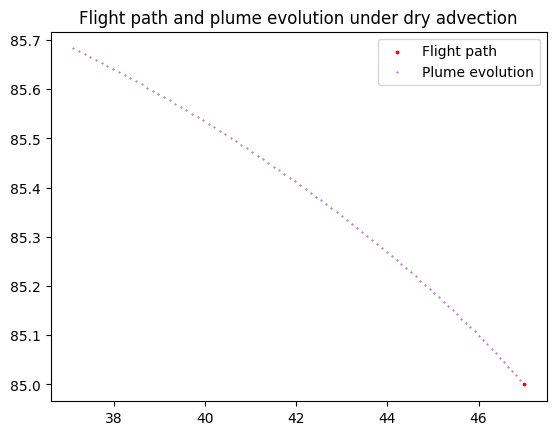

In [8]:
flight_attrs = {
    "flight_id": "test",
    # set constants along flight path
    "true_airspeed": 226.099920796651,  # true airspeed, m/s
    "thrust": 0.22,  # thrust_setting
    "nvpm_ei_n": 1.897462e15,  # non-volatile emissions index
    "aircraft_type": "E190",
    "wingspan": 48,  # m
    "n_engine": 2,
}

# Example flight
df = pd.DataFrame()
df["longitude"] = np.linspace(47, 47, 1)
df["latitude"] = np.linspace(85, 85, 1)
df["altitude"] = np.linspace(10900, 10900, 1)
df["engine_efficiency"] = np.linspace(0.34, 0.34, 1)
df["fuel_flow"] = np.linspace(2.1, 2.1, 1)  # kg/s
df["aircraft_mass"] = np.linspace(154445, 154445, 1)  # kg
df["time"] = pd.date_range("2020-02-25T01:00", "2020-02-25T01:00", periods=1)

fl = Flight(df, attrs=flight_attrs)

dt_integration = pd.Timedelta(minutes=2)
max_age = pd.Timedelta(hours=6)

params = {
    "dt_integration": dt_integration,
    "max_age": max_age,
    "depth": 1.0,  # initial plume depth, [m]
    "width": 1.0,  # initial plume width, [m]
}
dry_adv = DryAdvection(met, params)
dry_adv_df = dry_adv.eval(fl).dataframe

ax = plt.axes()

ax.scatter(fl["longitude"], fl["latitude"], s=3, color="red", label="Flight path")
ax.scatter(
    dry_adv_df["longitude"], dry_adv_df["latitude"], s=0.1, color="purple", label="Plume evolution"
)
ax.legend()
ax.set_title("Flight path and plume evolution under dry advection")

plt.show()